# **Imports**

In [323]:
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive

# shared access to google dirve
# drive where sim outputs are shared
# path may be different for group memebers
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/469CRP_group9/outputs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Computing Metrics**

In [380]:
def computeCycles(path):
    f = h5py.File(path, "r")

    dset = f["stats"]["root"]
    stats = dset[-1]
    coreStats = stats["westmere"]

    # from 8 cores add across all the processors
    return np.sum(coreStats["cycles"] + coreStats["cCycles"])

def computeIPC(path):
    # Since IPC is defined as a ratio, add all cycles and intr. first
    f = h5py.File(path, "r")

    dset = f["stats"]["root"]
    stats = dset[-1]
    coreStats = stats["westmere"]

    cycles = np.sum(coreStats["cycles"] + coreStats["cCycles"])  # Cycles
    intructions = np.sum(coreStats["instrs"])

    return intructions / cycles

def computeMPKI(path):
    f = h5py.File(path, "r")

    dset = f["stats"]["root"]
    stats = dset[-1]

    coreStats = stats["westmere"]
    intructions = np.sum(coreStats["instrs"])

    l3Stats = stats["l3"]
    misses = np.sum(l3Stats["mGETS"] + l3Stats["mGETXIM"] + l3Stats["mGETXSM"])

    return (misses/intructions) * 1000

def computeSpeedUp(replc1, replc2):
    return replc1 / replc2


def computeAvgSpeedUpMean(metrics):
    avg_speedup = {}

    for policy in metrics:
        raw_speedups = metrics[policy].get("speedUpOverLRU", [])

        # Convert to percentage and filter out NaNs
        clean_speedups = [
            s * 100 for s in raw_speedups if s is not None and not np.isnan(s)
        ]

        if clean_speedups:
            avg_speedup[policy] = np.mean(clean_speedups)
        else:
            avg_speedup[policy] = float('nan')

    return avg_speedup

#**Plot Metrics**

In [368]:
def plotNumCycles(metrics, benchmarks, colors, width, plotName, legend=True):
    plt.clf()
    plt.cla()
    bar_width = width
    index = np.arange(len(benchmarks))
    labels = list(metrics.keys())  # replc policies data

    # Plot each policy
    for i, label in enumerate(labels):
        numCycles = metrics[label]['cycles']  # grab the cycles list
        plt.bar(index + i*bar_width, numCycles, bar_width, color=colors[label], label=label)

    plt.xlabel("Benchmarks")
    plt.ylabel("Number of Cycles (1e8)")
    plt.xticks(index + bar_width / 2, benchmarks, rotation=75)
    plt.tight_layout()
    if legend: plt.legend()
    plt.savefig(plotName, dpi=500, bbox_inches="tight")

def plotIPC(metrics, benchmarks, colors, width, plotName, legend=True):
    plt.clf()
    plt.cla()
    bar_width = width
    index = np.arange(len(benchmarks))
    labels = list(metrics.keys())

    for i, label in enumerate(labels):
        ipc_values = metrics[label]['ipc']
        plt.bar(index + i * bar_width, ipc_values, bar_width, color=colors[label], label=label)

    plt.xlabel("Benchmarks")
    plt.ylabel("Instructions Per Cycle")
    plt.xticks(index + (bar_width * (len(labels) - 1) / 2), benchmarks, rotation=75)  # Center labels
    plt.tight_layout()
    if legend: plt.legend()
    plt.savefig(plotName, dpi=500, bbox_inches="tight")

def plotMPKI(metrics, benchmarks, colors, width, plotName, legend=True):
    plt.clf()
    plt.cla()
    bar_width = width
    index = np.arange(len(benchmarks))
    labels = list(metrics.keys())

    for i, label in enumerate(labels):
        mpki = metrics[label]['mpki']
        plt.bar(index + i * bar_width, mpki, bar_width, color=colors[label], label=label)

    plt.xlabel("Benchmarks")
    plt.ylabel("Misses Per 1K Instructions")
    plt.xticks(index + bar_width, benchmarks, rotation=75)
    plt.tight_layout()
    if legend: plt.legend()
    plt.savefig(plotName, dpi=500, bbox_inches="tight")
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plotSpeedUpOverLRU(metrics, benchmarks, colors, width, plotName, legend=True):
    plt.clf()
    plt.cla()

    bar_width = width
    index = np.arange(len(benchmarks))  # Make sure this is a 1D array
    selected_policies = ["Mockingjay", "RT-RRIP", "SRRIP"]

    for i, policy in enumerate(selected_policies):
        if "speedUpOverLRU" not in metrics[policy]:
            print(f"Warning: 'speedUpOverLRU' not found for {policy}")
            continue

        speedups = metrics[policy]["speedUpOverLRU"]

        # Ensure the data aligns with benchmarks
        if len(speedups) != len(benchmarks):
            print(f"Length mismatch for {policy}: {len(speedups)} values, {len(benchmarks)} benchmarks")
            continue

        plt.bar(index + i * bar_width,
                speedups,
                bar_width,
                color=colors[policy],
                label=policy)

    plt.xlabel("Benchmarks")
    plt.ylabel("Speedup Over LRU")

    # Properly center the benchmark labels under the grouped bars
    xtick_positions = index + bar_width * (len(selected_policies) - 1) / 2
    plt.xticks(xtick_positions, benchmarks, rotation=75)

    plt.tight_layout()
    if legend:
        plt.legend()
    plt.savefig(plotName, dpi=500, bbox_inches="tight")
    plt.show()


# **Data Collection**

In [326]:
suite = ["SPEC", "PARSEC"]
spec = ["bzip2", "gcc", "mcf", "hmmer", "xalan", "cactusADM",
        "namd", "calculix", "sjeng", "libquantum", "soplex", "lbm"]
parsec = ["blackscholes", "bodytrack", "fluidanimate", "streamcluster",
          "swaptions", "canneal", "x264"]
replc = ["LFU", "LRU", "Mockingjay", "NRU", "Rand", "RT-RRIP", "SRRIP",
         "TreeLRU", "Vantage"]
replc_colors = {
    "LFU": "#1f77b4",       # blue
    "LRU": "#ff7f0e",       # orange
    "Mockingjay": "#17becf",# teal
    "NRU": "#2ca02c",       # green
    "Rand": "#d62728",      # red
    "RT-RRIP": "#9467bd",   # purple
    "SRRIP": "#bcbd22",     # yellowish green
    "TreeLRU": "#8c564b",   # brown
    "Vantage": "#e377c2"    # pink
}
benchmarks = spec + parsec

metrics = {
    "LRU": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "LFU": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "Mockingjay": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "NRU": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "Rand": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "RT-RRIP": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "SRRIP": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "TreeLRU": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []},
    "Vantage": {"cycles": [], "ipc": [], "mpki": [], "speedUpOverLRU" : []}
}

for benchmark in benchmarks:
    suffix = "" if benchmark in spec else "_8c_simlarge"
    for policy in replc:
        pwd = path + "/" + policy + "/" + benchmark + suffix + "/zsim-ev.h5"
        metrics[policy]["cycles"].append(computeCycles(pwd))
        metrics[policy]["ipc"].append(computeIPC(pwd))
        metrics[policy]["mpki"].append(computeMPKI(pwd))


for policy in replc:
    metrics[policy]["speedUpOverLRU"] = []
    for i in range(len(benchmarks)):
        lru_cycles = metrics["LRU"]["cycles"][i]
        policy_cycles = metrics[policy]["cycles"][i]

        if policy == "LRU":
            speedup = 1.0
        else:
            speedup = lru_cycles / policy_cycles if policy_cycles != 0 else float('nan')

        metrics[policy]["speedUpOverLRU"].append(speedup)

<ipython-input-324-cb59f75b84cc>:22: RuntimeWarning: invalid value encountered in scalar divide
  return intructions / cycles
<ipython-input-324-cb59f75b84cc>:36: RuntimeWarning: invalid value encountered in scalar divide
  return (misses/intructions) * 1000


# **Results**

Metric Latex Tables

In [382]:
avg_speedup_percent = computeAvgSpeedUpMean(metrics)  # already returns values as % now
avg_speedup_df = pd.DataFrame([avg_speedup_percent], index=["Average Speedup (%)"])
avg_speedup_table = avg_speedup_df.to_latex(float_format="%.1f",
                                            caption="Average Speedup Over LRU (in Percentage)",
                                            label="tab:avgSpeedup")

print(avg_speedup_table)
with open("avgSpeedup_table.tex", "w") as f:
    f.write(avg_speedup_table)

\begin{table}
\caption{Average Speedup Over LRU (in Percentage)}
\label{tab:avgSpeedup}
\begin{tabular}{lrrrrrrrrr}
\toprule
 & LRU & LFU & Mockingjay & NRU & Rand & RT-RRIP & SRRIP & TreeLRU & Vantage \\
\midrule
Average Speedup (%) & 100.0 & 102.7 & 103.0 & 102.6 & 103.3 & 105.1 & 104.1 & 101.0 & 103.2 \\
\bottomrule
\end{tabular}
\end{table}



In [327]:
numOfCycles_data = {policy: metrics[policy]['cycles'] for policy in replc}
numOfCycles_df = pd.DataFrame(numOfCycles_data, index=benchmarks)
numOfCycles_table = numOfCycles_df.to_latex(index=True, float_format="%.2f",
                          caption="Number of Cycles", label="tab:numOfCycles")

print(numOfCycles_table)
with open("numOfCycles_table.tex", "w") as f:
  f.write(numOfCycles_table)

\begin{table}
\caption{Number of Cycles}
\label{tab:numOfCycles}
\begin{tabular}{lrrrrrrrrr}
\toprule
 & LFU & LRU & Mockingjay & NRU & Rand & RT-RRIP & SRRIP & TreeLRU & Vantage \\
\midrule
bzip2 & 115270580 & 117272918 & 125144356 & 118323944 & 129000278 & 114896258 & 118394286 & 116058451 & 117030819 \\
gcc & 133039774 & 131710382 & 125053863 & 123560763 & 131825982 & 122442939 & 131317995 & 126673722 & 130826127 \\
mcf & 775032709 & 800613388 & 810294598 & 801407877 & 801748155 & 791607765 & 791607765 & 799839921 & 800827226 \\
hmmer & 69517922 & 70467882 & 68293906 & 67595611 & 68190328 & 67677505 & 70572214 & 68275028 & 68377109 \\
xalan & 67279166 & 68003073 & 72089106 & 71388128 & 73984332 & 70428894 & 68731932 & 70268905 & 70868361 \\
cactusADM & 94155323 & 94416762 & 126464492 & 94343854 & 94162019 & 94478633 & 94478633 & 94499040 & 94627789 \\
namd & 55385732 & 55385128 & 53703894 & 53717289 & 54021501 & 53703940 & 55413381 & 53703437 & 53703951 \\
calculix & 50460626 & 5045

In [328]:
ipc_data = {policy: metrics[policy]['ipc'] for policy in replc}
ipc_df = pd.DataFrame(ipc_data, index=benchmarks)
ipc_table = ipc_df.to_latex(index=True, float_format="%.2f",
                          caption="IPC", label="tab:ipc")

print(ipc_table)
with open("ipc_table.tex", "w") as f:
  f.write(ipc_table)

\begin{table}
\caption{IPC}
\label{tab:ipc}
\begin{tabular}{lrrrrrrrrr}
\toprule
 & LFU & LRU & Mockingjay & NRU & Rand & RT-RRIP & SRRIP & TreeLRU & Vantage \\
\midrule
bzip2 & 0.87 & 0.85 & 0.80 & 0.85 & 0.78 & 0.87 & 0.84 & 0.86 & 0.85 \\
gcc & 0.75 & 0.76 & 0.80 & 0.81 & 0.76 & 0.82 & 0.76 & 0.79 & 0.76 \\
mcf & 0.13 & 0.12 & 0.12 & 0.12 & 0.12 & 0.13 & 0.13 & 0.13 & 0.12 \\
hmmer & 1.44 & 1.42 & 1.46 & 1.48 & 1.47 & 1.48 & 1.42 & 1.46 & 1.46 \\
xalan & 1.49 & 1.47 & 1.39 & 1.40 & 1.35 & 1.42 & 1.46 & 1.42 & 1.41 \\
cactusADM & 1.06 & 1.06 & 0.79 & 1.06 & 1.06 & 1.06 & 1.06 & 1.06 & 1.06 \\
namd & 1.81 & 1.81 & 1.86 & 1.86 & 1.85 & 1.86 & 1.80 & 1.86 & 1.86 \\
calculix & 1.98 & 1.98 & NaN & 1.98 & 1.98 & 1.98 & 1.98 & 1.98 & 1.98 \\
sjeng & 1.16 & 1.16 & 1.15 & 1.15 & 1.15 & 1.15 & 1.15 & 1.16 & 1.15 \\
libquantum & 0.51 & 0.51 & 0.51 & 0.51 & 0.51 & 0.51 & 0.51 & 0.51 & 0.51 \\
soplex & 0.37 & 0.37 & 0.37 & 0.37 & 0.36 & 0.38 & 0.37 & 0.37 & 0.37 \\
lbm & 0.57 & 0.57 & 0.57 & 0.57

In [329]:
mpki_data = {policy: metrics[policy]['mpki'] for policy in replc}
mpki_df = pd.DataFrame(mpki_data, index=benchmarks)
mpki_table = mpki_df.to_latex(index=True, float_format="%.2f",
                          caption="MPKI", label="tab:mpki")

print(mpki_table)
with open("mpki_table.tex", "w") as f:
  f.write(mpki_table)

\begin{table}
\caption{MPKI}
\label{tab:mpki}
\begin{tabular}{lrrrrrrrrr}
\toprule
 & LFU & LRU & Mockingjay & NRU & Rand & RT-RRIP & SRRIP & TreeLRU & Vantage \\
\midrule
bzip2 & 2.82 & 2.94 & 3.75 & 3.18 & 4.35 & 2.72 & 3.05 & 2.86 & 2.94 \\
gcc & 2.96 & 2.88 & 2.35 & 2.27 & 2.86 & 2.20 & 2.86 & 2.49 & 2.76 \\
mcf & 77.31 & 81.02 & 83.53 & 81.30 & 83.45 & 79.46 & 79.46 & 80.92 & 81.09 \\
hmmer & 1.46 & 1.53 & 1.54 & 1.50 & 1.51 & 1.46 & 1.57 & 1.65 & 1.54 \\
xalan & 1.59 & 1.68 & 2.02 & 2.00 & 2.12 & 1.90 & 1.72 & 1.94 & 1.97 \\
cactusADM & 4.77 & 4.83 & 8.50 & 4.78 & 4.76 & 4.79 & 4.79 & 4.84 & 5.08 \\
namd & 0.37 & 0.37 & 0.27 & 0.27 & 0.29 & 0.27 & 0.37 & 0.27 & 0.27 \\
calculix & 0.06 & 0.06 & NaN & 0.06 & 0.06 & 0.06 & 0.06 & 0.06 & 0.06 \\
sjeng & 0.36 & 0.36 & 0.37 & 0.37 & 0.38 & 0.37 & 0.37 & 0.36 & 0.38 \\
libquantum & 25.05 & 25.05 & 25.05 & 25.05 & 25.05 & 25.07 & 25.07 & 25.05 & 24.80 \\
soplex & 21.34 & 21.68 & 22.72 & 22.16 & 23.46 & 21.52 & 21.72 & 22.39 & 22.34 \\
lb

Metric Bar Charts

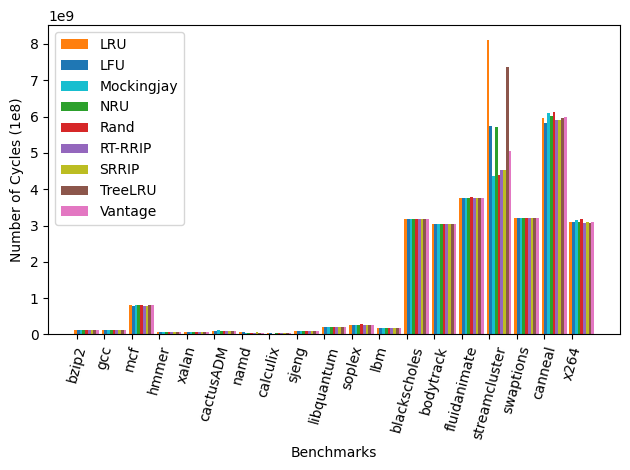

In [330]:
plotNumCycles(metrics, benchmarks, replc_colors, 0.1, "numOfCycles.png")

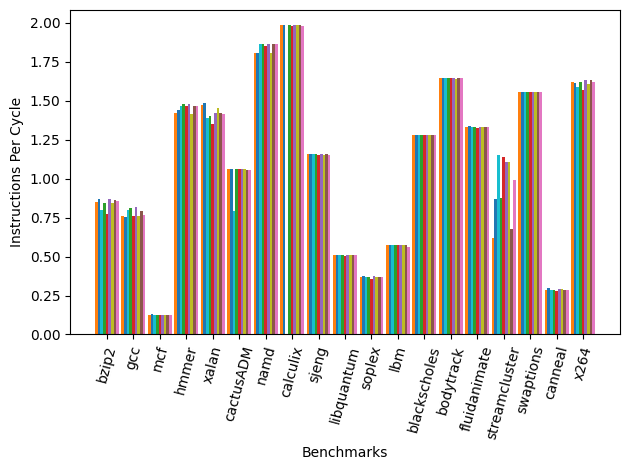

In [331]:
plotIPC(metrics, benchmarks, replc_colors, 0.1, "IPC.png", False) # omit legend to view chart

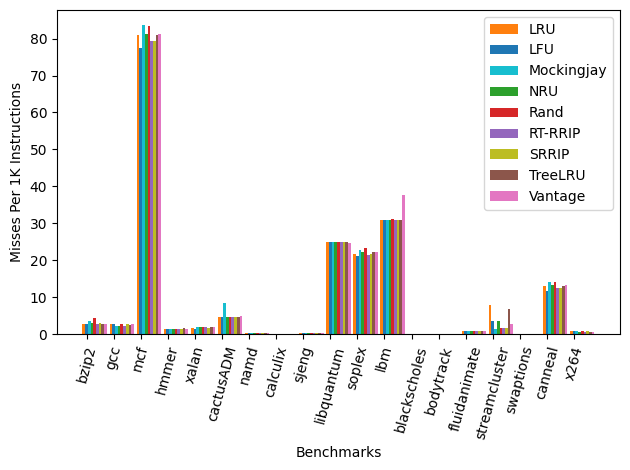

In [332]:
plotMPKI(metrics, benchmarks, replc_colors, 0.1, "MPKI.png")

# **SPEC CPU2006 Results**

In [333]:
# recall benchmarks = spec + parsec
specMetrics = {}
for policy in metrics:
  specMetrics[policy] = {
      'cycles': metrics[policy]['cycles'][0:len(spec)],
      'ipc'   : metrics[policy]['ipc'][0:len(spec)],
      'mpki'  : metrics[policy]['mpki'][0:len(spec)]
  }

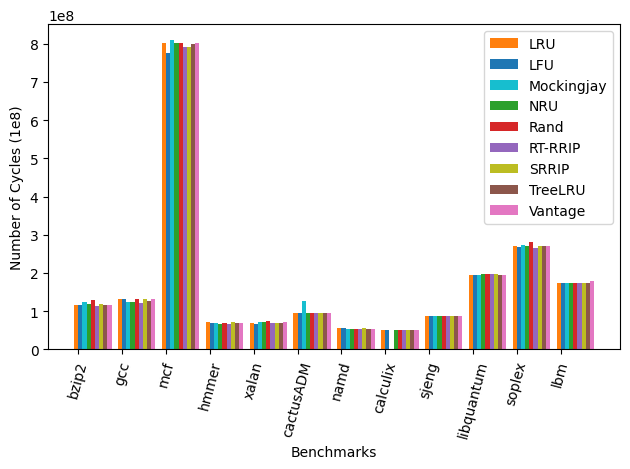

In [334]:
plotNumCycles(specMetrics, spec, replc_colors, 0.095, "specNumOfCycles.png")

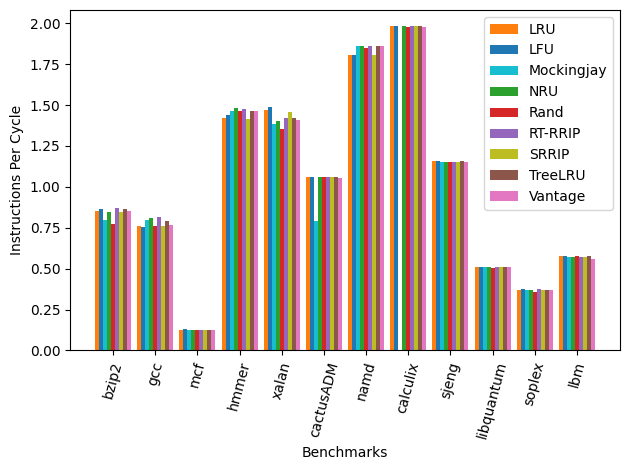

In [335]:
plotIPC(specMetrics, spec, replc_colors, 0.095, "specIPC.png")

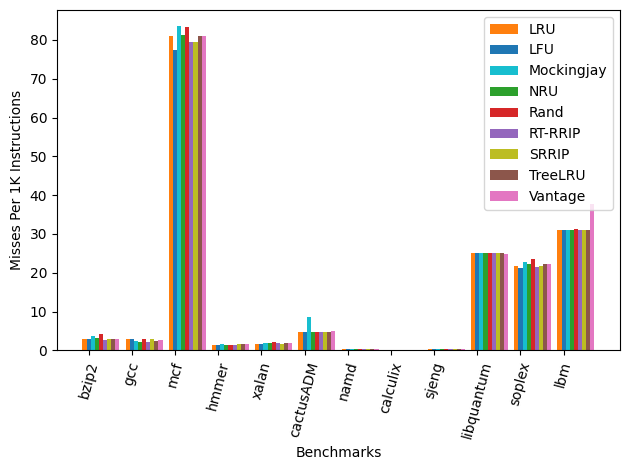

In [336]:
plotMPKI(specMetrics, spec, replc_colors, 0.095, "specMPKI.png")

# **PARSEC Results**

In [337]:
# recall benchmarks = spec + parsec
parsecMetrics = {}
for policy in metrics:
  parsecMetrics[policy] = {
      'cycles': metrics[policy]['cycles'][len(spec):],
      'ipc'   : metrics[policy]['ipc'][len(spec):],
      'mpki'  : metrics[policy]['mpki'][len(spec):]
  }

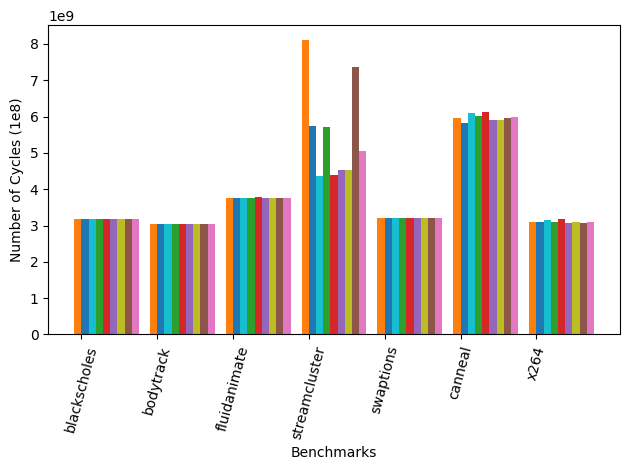

In [338]:
plotNumCycles(parsecMetrics, parsec, replc_colors, 0.095, "parsecNumOfCycles.png", False)

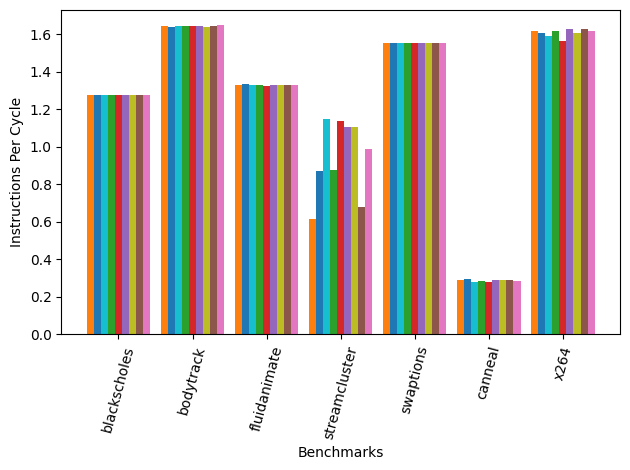

In [339]:
plotIPC(parsecMetrics, parsec, replc_colors, 0.095, "parsecIPC.png", False)

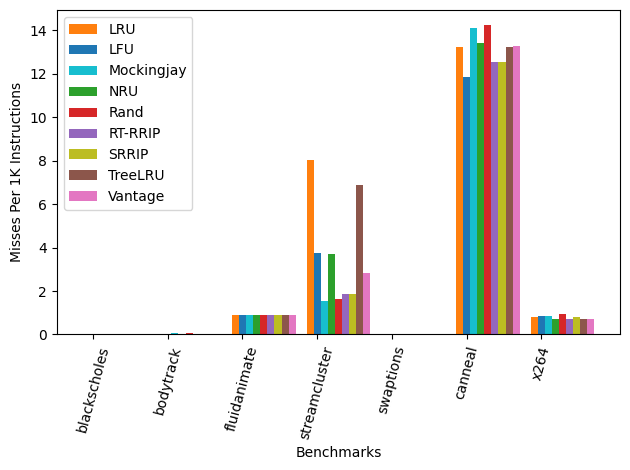

In [340]:
plotMPKI(parsecMetrics, parsec, replc_colors, 0.095, "parsecMPKI.png")

# **Speed Up Over LRU**

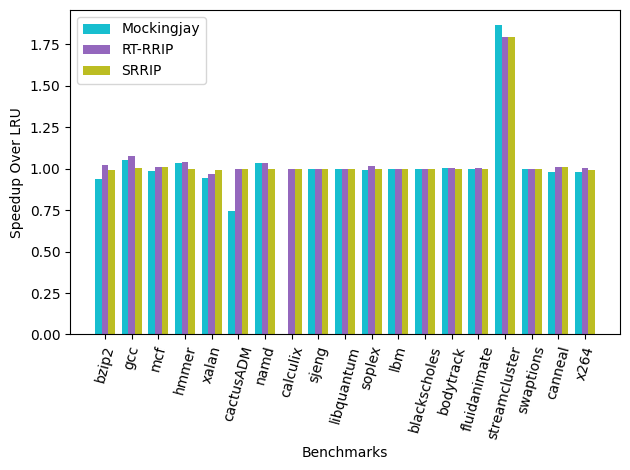

In [373]:
plotSpeedUpOverLRU(metrics, benchmarks, replc_colors, 0.25, "SpeedUpOverLRU.png")